# Running the ICML 2018 Experiments

In this series of notebooks, we will replicate and analyze the ICML 2018 experiments that where used for benchmarking in <a href="http://proceedings.mlr.press/v80/falkner18a.html" target="_blank">BOHB (Falkner et al. 2018)</a>.
In addition to <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a>, we will use <a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> to analyze and visualize the optimization process.

## About the frameworks

### BNN

This experiment optimizes a Bayesian Neural Network (BNN) (TODO: add info)

### Installation requirements

You need to install HpBandSter and CAVE to run this example. Both can be installed using pip (i.e. `pip install cave hpbandster`).

## Run the experiment


In [1]:
# We deactivate logging to ensure readability
import logging
logging.basicConfig(level=logging.ERROR)
# Also, we suppress warnings.
# If there are problems for you executing this notebook, you might want to comment this out.
import warnings
warnings.filterwarnings("ignore")

### 1.1) Preparing BOHB
*Worker*: We need a <a href="https://automl.github.io/HpBandSter/build/html/core/worker.html" target="_blank">Worker</a> to define the kind of computation we want to optimize. The worker used for the experiments is located in `workers/bnn_worker.py`

*ConfigSpace*: Every problem needs a description of the search space to be complete. In HpBandSter, a ConfigurationSpace-object defines all hyperparameters, their ranges and dependencies between them.

In our example here, the search space consists of the hyperparameters:


|  Name     |  Type   |      Values  |
|:---------:|:-------:|:------------:|
| burn_in   | float   | [0.0, 0.8]   |
| l_rate    | float   | [1e-06, 0.1] |
| mdecay    | float   | [0.0, 1.0]   |
| n_units_1 | float   | [16, 512]    |
| n_units_2 | float   | [16, 512]    |

In [2]:
from workers.bnn_worker import BNNWorker

### 1.3) Setting up the HpBandSter Nameserver and starting the optimization run

In [3]:
import os

dataset = "bostonhousing"  # alternatives are ['toyfunction', 'bostonhousing', 'proteinstructure', 'yearprediction']
opt_method="bohb"
output_dir = "results/bnn/"  # This is the destination for the BOHB-results
num_iterations = 4

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Step 1 - initiating communication, creating a nameserver:
The <a href="https://automl.github.io/HpBandSter/build/html/core/nameserver.html" target="_blank">nameserver</a> is a small service that keeps track of all running processes and their IP addresses and ports. It could be a 'static' server with a permanent address, but here it will be started for the local machine with a random port. 

In [4]:
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB, RandomSearch, HyperBand

run_id = '0'  # Every run has to have a unique (at runtime) id.

# setup a nameserver
NS = hpns.NameServer(run_id=run_id, host='localhost', port=0, working_directory=output_dir)
ns_host, ns_port = NS.start()

#### Step 2 - creating the worker: 
The worker implements the actual problem that is optimized. Its 'compute'-method will be called later by the BOHB-optimizer repeatedly with the sampled configurations and return the computed loss (and additional information).

In [5]:
worker = BNNWorker(dataset=dataset, measure_test_loss=False, run_id=run_id, max_budget=10000)
configspace = worker.configspace

worker.load_nameserver_credentials(output_dir)
worker.run(background=True)

#### Step 3:  
Create an optimizer object, which samples configurations from the ConfigurationSpace, using succesive halving to assign budgets for execution. Further information on what qualifies as a budget <a href="https://automl.github.io/HpBandSter/build/html/quickstart.html#meaningful-budgets-and-number-of-iterations" target="_blank">can be found in the documentation.</a>

**NOTE:** BOHB does not build a new model at the beginning of every SuccessiveHalving run. Instead it collects all evaluations on all budgets and uses the largest budget with enough evaluations as a base for future evaluations.  

In [6]:
%%capture
eta = 3
opt = None

if opt_method == 'randomsearch':
    opt = RandomSearch      
elif opt_method == 'bohb':
    opt = BOHB              
elif opt_method == 'hyperband':
    opt = HyperBand
else:
    raise ValueError("Unknown method %s" % opt_method)

result_logger = hpres.json_result_logger(directory=output_dir, overwrite=True)

opt = opt(configspace, eta=3,
          working_directory=output_dir,
          run_id=run_id,
          min_budget=300, max_budget=10000,
          host=ns_host,
          nameserver=ns_host,
          nameserver_port = ns_port,
          ping_interval=3600,
          result_logger=result_logger)

result = opt.run(n_iterations=num_iterations)

**NOTE:** Unfortunately, the configuration space is *not saved automatically* to file but this step is mandatory for the analysis with CAVE.  
We recommend to save the configuration space every time you use BOHB.
We do this by using the ConfigSpace-to-json-writer.

In [7]:
from ConfigSpace.read_and_write import pcs_new
with open(os.path.join(output_dir, 'configspace.pcs'), 'w') as fh:
    fh.write(pcs_new.write(opt.config_generator.configspace))

The <a href="https://automl.github.io/HpBandSter/build/html/core/result.html" target="_blank">Result-object</a> offers access to basic statistics, as well as the best configuration (incumbent) and the trajectory.

## Using the results in CAVE

### 2.1) Creating a HTML-report with CAVE

Creating the report with CAVE is very straight-forward. Simply provide the output-directory of the BOHB-analysis in CAVE's `--folders` argument and specify `--file_format` as `BOHB`. You can do this by commandline ('!' simply executes the command as if it was executed on the command line):


In [8]:
%%capture
! cave --folders results/bnn --file_format BOHB --output CAVE_reports/bnn_bash --verbose_level OFF

After CAVE finished the report, you can have a look at it with your favorite browser.

In [9]:
! firefox ./CAVE_reports/bnn_bash/report.html

### 2.2) Using CAVE from within Python

Of course you can use CAVE on a module-level. Import and instantiate it (very similarily to the commandline). By default, CAVE even outputs all analysis results in a jupyter-cell-compatible way. Of course, the HTML-report is built meanwhile, so you don't have to run time-consuming analyzing-methods repeatedly.

In [4]:
from cave.cavefacade import CAVE

cave = CAVE(folders=[output_dir],
            output_dir="CAVE_reports/bnn_notebook",
            ta_exec_dir=["."],
            file_format='BOHB',
            verbose_level='OFF',
            show_jupyter=True
           )

The most interesting plot for BOHB might be a visualization of the learning curves:

In [ ]:
cave.bohb_learning_curves()

We can access the individual budgets via the 'run'-keyword-argument of each analysis-method.

In [5]:
cave.overview_table()

For each budget, we can list the cost over incumbents:

In [6]:
cave.bohb_incumbents_per_budget()

,budget 370.3703703703703,budget 1111.111111111111,budget 3333.333333333333,budget 10000
burn_in,0.111592,0.192454,0.150875,0.192454
l_rate,0.0155493,0.0649133,0.0617508,0.0649133
mdecay,0.737616,0.353088,0.275103,0.353088
n_units_1,172,25,51,25
n_units_2,239,19,17,19
Cost,14.363,3.692,4.204,4.514


For parameter-importance analysis, CAVE uses <a href="https://github.com/automl/ParameterImportance" target="_blank">PIMP</a> , a package that provides multiple approaches to parameter-importance analysis. We can easily invoke them via CAVE, of course. To estimate the importance, random forests are used to predict performances of configurations that were not executed. This is difficult for big budgets with few configurations.

In [7]:
cave.cave_fanova(run='budget_370.3703703703703')

-------------------- Single importance: --------------------,--------------------
burn_in,43.4028 +/- 47.3895
mdecay,15.982 +/- 34.4744
n_units_1,15.2503 +/- 33.7393
l_rate,13.4742 +/- 32.9184
n_units_2,1.1384 +/- 4.3776
-------------------- Pairwise importance: --------------------,--------------------
mdecay & l_rate,5.2755 +/- 20.432
burn_in & n_units_1,2.8332 +/- 10.9728
burn_in & mdecay,2.3413 +/- 9.0659
burn_in & n_units_2,0.3021 +/- 1.1575


In [8]:
cave.local_parameter_importance(run='budget_370.3703703703703')

For each budget, we can compare the different parameter-importance-methods that have already been run:

In [9]:
cave.pimp_comparison_table(run='budget_370.3703703703703')

Loading BokehJS ...

To analyze BOHB's behaviour, we can check out the configurator footprint, cost-over-time and parallel coordinated parameters:

In [10]:
cave.configurator_footprint(use_timeslider=True, num_quantiles=5)

Loading BokehJS ...

In [11]:
cave.cost_over_time()

Loading BokehJS ...

/home/shuki/Repos/BOHBsCAVE/.ve_BOHBsCAVE/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


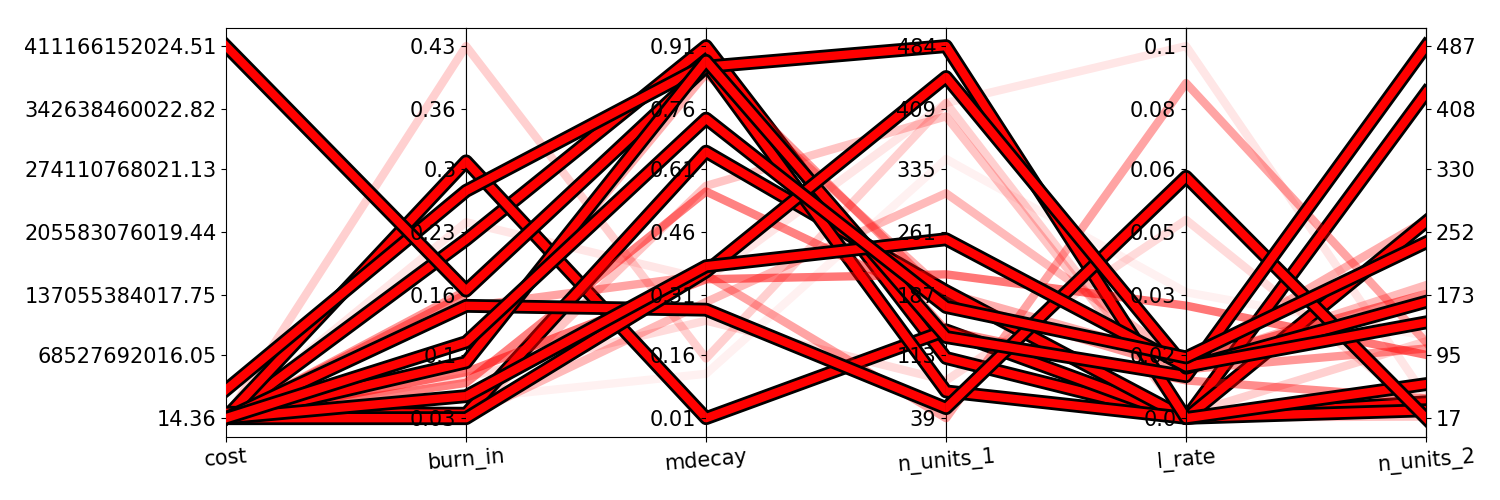

In [12]:
cave.parallel_coordinates(run='budget_370.3703703703703')